<a href="https://colab.research.google.com/github/audreyemmely/masters-study-codes/blob/main/exploring_fairness_germancredit_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Fairness analysis of german credit dataset
Dataset: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif

df = pd.read_csv('/content/german_credit_data.csv', index_col=0)
eda_df = df.copy()

In [2]:
print(len(eda_df))
eda_df.head()

1000


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Exploratory analysis

In [3]:
eda_df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [4]:
eda_df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [5]:
print("Saving accounts", eda_df['Saving accounts'].unique())
print("Checking accounts", eda_df['Checking account'].unique())

Saving accounts [nan 'little' 'quite rich' 'rich' 'moderate']
Checking accounts ['little' 'moderate' nan 'rich']


In [6]:
eda_df["Saving accounts"].fillna("none", inplace=True)
eda_df["Checking account"].fillna("none", inplace=True)
eda_df.isna().any()

Age                 False
Sex                 False
Job                 False
Housing             False
Saving accounts     False
Checking account    False
Credit amount       False
Duration            False
Purpose             False
Risk                False
dtype: bool

In [7]:
eda_df['Age'].value_counts().nlargest(5)

27    51
26    50
23    48
24    44
28    43
Name: Age, dtype: int64

In [8]:
age_bins = list(range(18, 110, 10))

eda_df['age_range'] = pd.cut(eda_df['Age'], bins=age_bins, labels=False, right=False)

age_ranges = [f'{start}-{end-1}' for start, end in zip(age_bins, age_bins[1:])]

eda_df['age_range'] = eda_df['age_range'].replace(range(len(age_ranges)), age_ranges)

print(eda_df[['Age', 'age_range']])

     Age age_range
0     67     58-67
1     22     18-27
2     49     48-57
3     45     38-47
4     53     48-57
..   ...       ...
995   31     28-37
996   40     38-47
997   38     38-47
998   23     18-27
999   27     18-27

[1000 rows x 2 columns]


In [9]:
eda_df['age_range'].value_counts().nlargest(5)

28-37    365
18-27    291
38-47    193
48-57     92
58-67     49
Name: age_range, dtype: int64

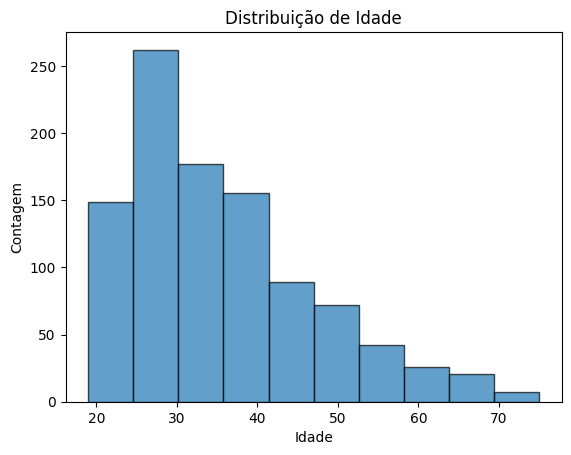

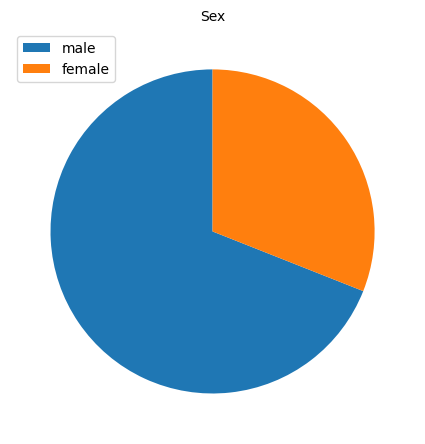

In [10]:
plt.hist(eda_df['Age'], bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Idade')
plt.ylabel('Contagem')
plt.title('Distribuição de Idade')
plt.show()

counts = eda_df['Sex'].value_counts()
labels = counts.index
plt.pie(counts, startangle=90)
plt.legend(labels, loc=2,fontsize=10)
plt.title("Sex",size=10)
plt.tight_layout(pad=2)

In [11]:
df_fair = eda_df[['age_range', 'Sex']].copy()

# # protected variables
df_fair['priv_age'] = [1 if a == '28-37' else 0 for a in df_fair['age_range']]
df_fair['priv_sex'] = [1 if s == 'male' else 0 for s in df_fair['Sex']]

# target
df_fair['risk'] = [1 if r == 'good' else 0 for r in df['Risk']]

# df_fair.head()

In [12]:
df_fair

,age_range,Sex,priv_age,priv_sex,risk
0,58-67,male,0,1,1
1,18-27,female,0,0,0
2,48-57,male,0,1,1
3,38-47,male,0,1,1
4,48-57,male,0,1,0
...,...,...,...,...,...
995,28-37,female,1,0,1
996,38-47,male,0,1,1
997,38-47,male,0,1,1
998,18-27,male,0,1,0


In [13]:
#Calculate prevelance
#prevalence is the proportion of positive cases overall cases
#prevalence = p/n
prev = df_fair['risk'].mean()
prev_race = df_fair.groupby('priv_age')['risk'].mean()
prev_sex = df_fair.groupby('priv_sex')['risk'].mean()
prev_comb = df_fair.groupby(['priv_age','priv_sex'])['risk'].mean()

print(prev)
print(prev_race)
print(prev_sex)
print(prev_comb)

0.7
priv_age
0    0.692913
1    0.712329
Name: risk, dtype: float64
priv_sex
0    0.648387
1    0.723188
Name: risk, dtype: float64
priv_age  priv_sex
0         0           0.662037
          1           0.708831
1         0           0.617021
          1           0.745387
Name: risk, dtype: float64
